<center><img src='https://www.kdnuggets.com/images/sentiment-fig-1-689.jpg' height="200" width="500"></center>
<h1><center>Tweet Sentiment Extraction</center></h1>
<h2><center>Extract support phrases for sentiment labels</center></h2>

In this competition our objective is to construct a model that can look at the labeled sentiment for a given tweet and figure out what word or phrase best supports it.
(work in progress)

## Dependencies

In [1]:
import random, warnings
import pandas as pd
import seaborn as sns
from nltk import FreqDist
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

SEED = 0
warnings.filterwarnings("ignore")

In [2]:
# Auxiliary functions
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def evaluate_model(train_set, validation_set):
    train_set['jaccard'] = train_set.apply(lambda x: jaccard(x['selected_text'], x['prediction']), axis=1)
    validation_set['jaccard'] = validation_set.apply(lambda x: jaccard(x['selected_text'], x['prediction']), axis=1)

    print('Train set Jaccard: %.3f' % train_set['jaccard'].mean())
    print('Validation set Jaccard: %.3f' % validation_set['jaccard'].mean())

    print('\nMetric by sentiment')
    for sentiment in train_df['sentiment'].unique():
        print('\nSentiment == %s' % sentiment)
        print('Train set Jaccard: %.3f' % train_set[train_set['sentiment'] == sentiment]['jaccard'].mean())
        print('Validation set Jaccard: %.3f' % validation_set[validation_set['sentiment'] == sentiment]['jaccard'].mean())

## Load data

In [3]:
train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')

print('Train samples: %s' % len(train))
print('Test samples: %s' % len(test))
display(train.head())

Train samples: 27486
Test samples: 3535


,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive


 # EDA
 
 # First let's look at some samples

In [4]:
sample_0 = 0
sample_1 = 1
sample_2 = 2

print('Example %d' % sample_0)
print('Text: %s' % train['text'].values[sample_0])
print('Sentiment: %s' % train['sentiment'].values[sample_0])
print('Selected text (label): %s' % train['selected_text'].values[sample_0])

print('\nExample %d' % sample_1)
print('Text: %s' % train['text'].values[sample_1])
print('Sentiment: %s' % train['sentiment'].values[sample_1])
print('Selected text (label): %s' % train['selected_text'].values[sample_1])

print('\nExample %d' % sample_2)
print('Text: %s' % train['text'].values[sample_2])
print('Sentiment: %s' % train['sentiment'].values[sample_2])
print('Selected text (label): %s' % train['selected_text'].values[sample_2])

Example 0
Text: Spent the entire morning in a meeting w/ a vendor, and my boss was not happy w/ them. Lots of fun.  I had other plans for my morning
Sentiment: neutral
Selected text (label): my boss was not happy w/ them. Lots of fun.

Example 1
Text:  Oh! Good idea about putting them on ice cream
Sentiment: positive
Selected text (label): Good

Example 2
Text: says good (or should i say bad?) afternoon!  http://plurk.com/p/wxpdj
Sentiment: neutral
Selected text (label): says good (or should i say bad?) afternoon!


# Sentiment distribution

As we can see the distribution of the sentiment feature is practically the same between train and test sets.

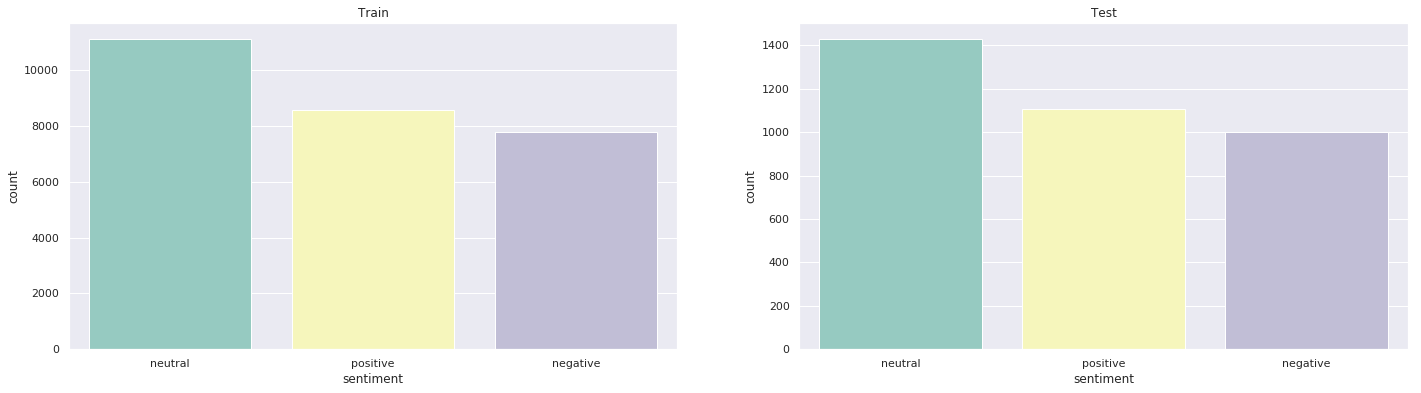

In [5]:
sentiment_order = train['sentiment'].unique()
sns.set(style="darkgrid")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
sns.countplot(x='sentiment', data=train, palette="Set3", order=sentiment_order, ax=ax1).set_title("Train")
sns.countplot(x='sentiment', data=test, palette="Set3", order=sentiment_order, ax=ax2).set_title("Test")
plt.show()

# Text data statistics

# Text length and word count

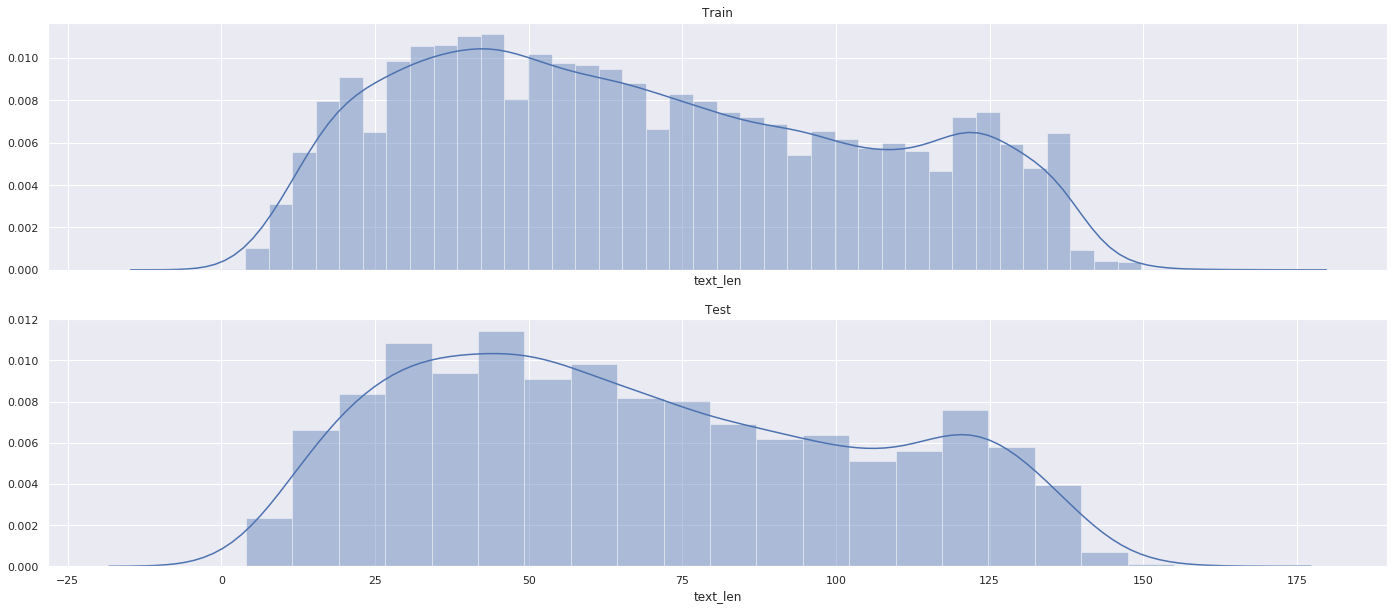

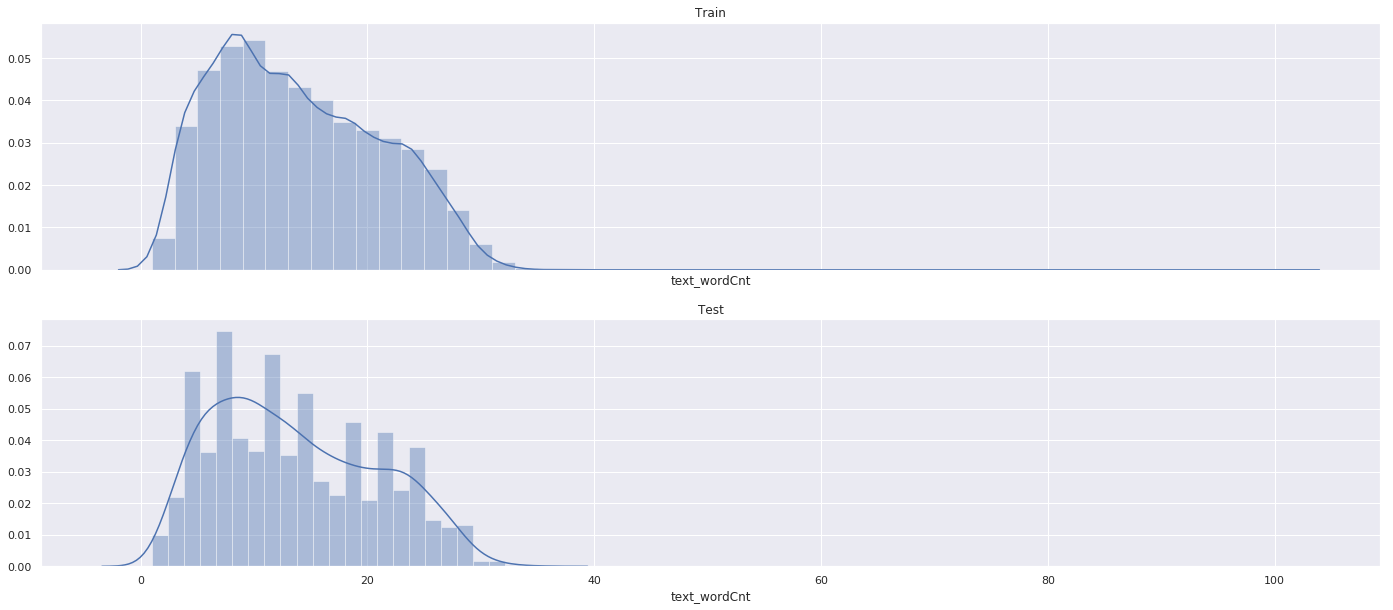

In [6]:
train['text'].fillna('', inplace=True)
train['selected_text'].fillna('', inplace=True)

train['text_len'] = train['text'].apply(lambda x : len(x))
train['text_wordCnt'] = train['text'].apply(lambda x : len(x.split(' ')))
train['selected_text_len'] = train['selected_text'].apply(lambda x : len(x))
train['selected_text_wordCnt'] = train['selected_text'].apply(lambda x : len(x.split(' ')))
test['text_len'] = test['text'].apply(lambda x : len(x))
test['text_wordCnt'] = test['text'].apply(lambda x : len(x.split(' ')))

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 10), sharex=True)
sns.distplot(train['text_len'], ax=ax1).set_title("Train")
sns.distplot(test['text_len'], ax=ax2).set_title("Test")
plt.show()

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 10), sharex=True)
sns.distplot(train['text_wordCnt'], ax=ax1).set_title("Train")
sns.distplot(test['text_wordCnt'], ax=ax2).set_title("Test")
plt.show()

# Selected text (label) length and word count

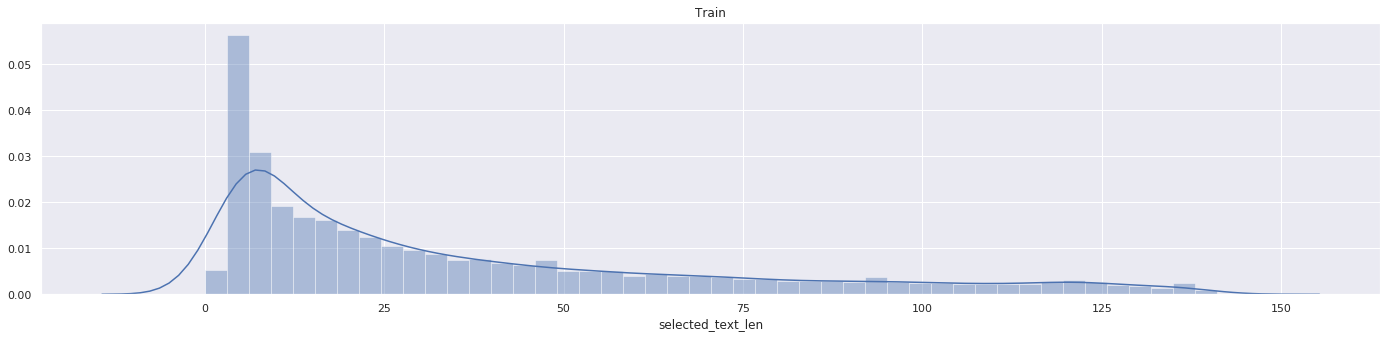

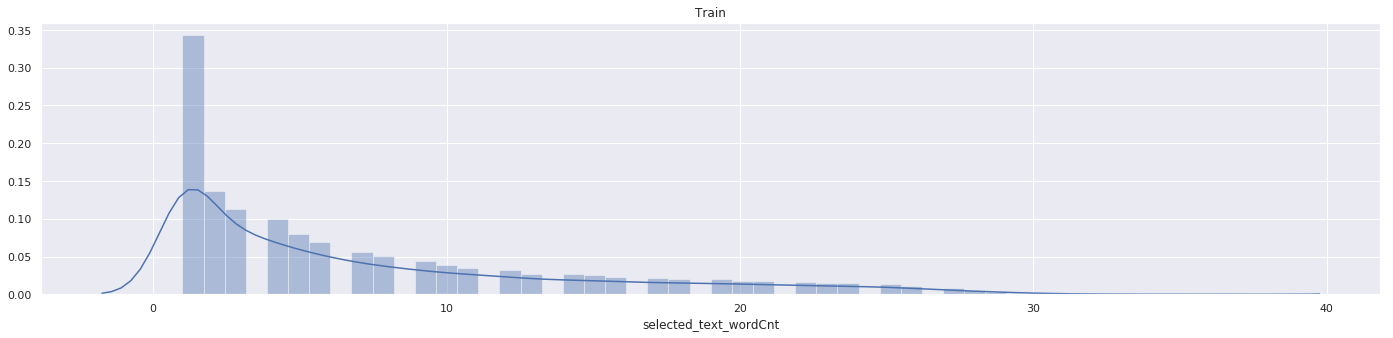

In [7]:
f, ax = plt.subplots(1, 1, figsize=(24, 5), sharex=True)
sns.distplot(train['selected_text_len'], ax=ax).set_title("Train")
plt.show()

f, ax = plt.subplots(1, 1, figsize=(24, 5), sharex=True)
sns.distplot(train['selected_text_wordCnt'], ax=ax).set_title("Train")
plt.show()

# Train set word frequency

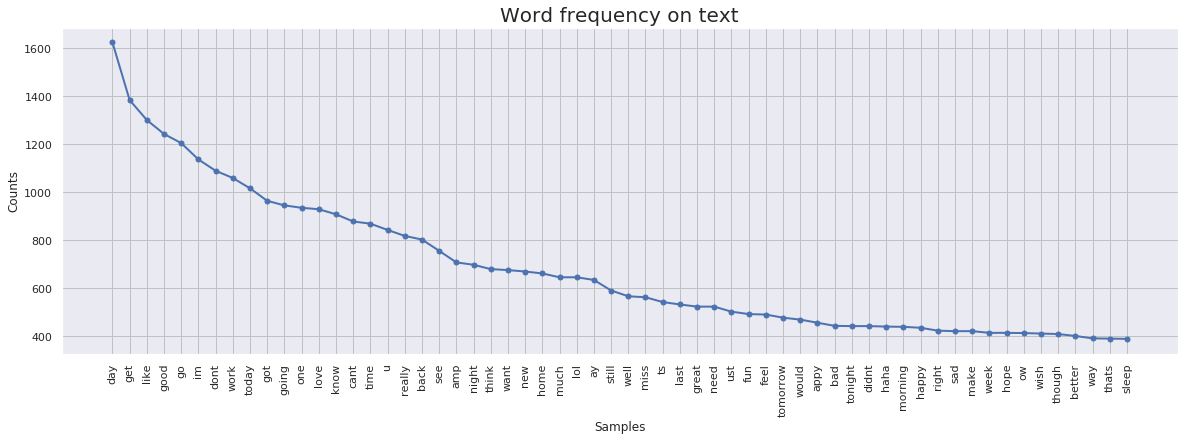

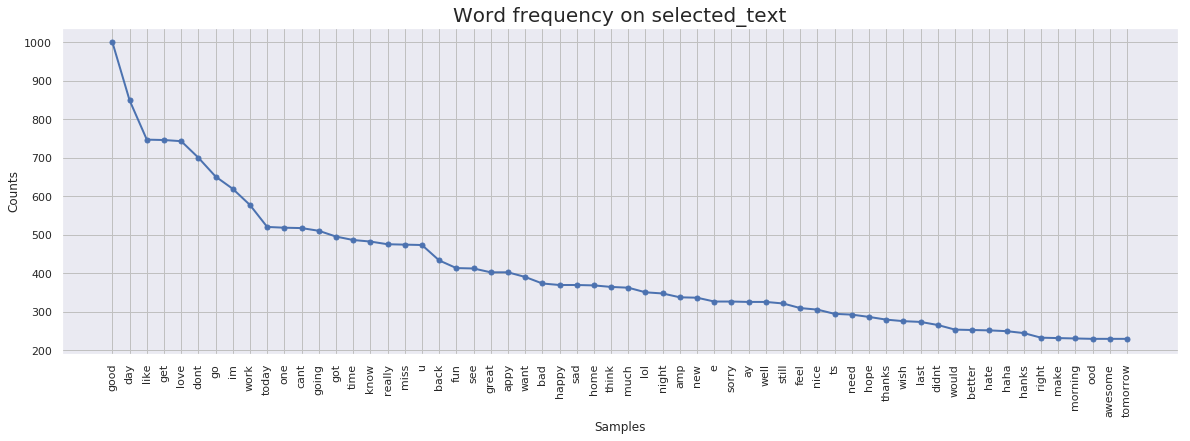

In [8]:
eng_stopwords = stopwords.words('english')

train['text'] = train['text'].str.replace('[^a-z ]','')
train['selected_text'] = train['selected_text'].str.replace('[^a-z ]','')
train['text'] = train['text'].apply(lambda x: x.lower())
train['selected_text'] = train['selected_text'].apply(lambda x: x.lower())

freq_dist = FreqDist([word for comment in train['text'] for word in comment.split() if word not in eng_stopwords])
plt.figure(figsize=(20, 6))
plt.title('Word frequency on text').set_fontsize(20)
freq_dist.plot(60, marker='.', markersize=10)
plt.show()

freq_dist = FreqDist([word for comment in train['selected_text'] for word in comment.split() if word not in eng_stopwords])
plt.figure(figsize=(20, 6))
plt.title('Word frequency on selected_text').set_fontsize(20)
freq_dist.plot(60, marker='.', markersize=10)
plt.show()

# Test set word frequency

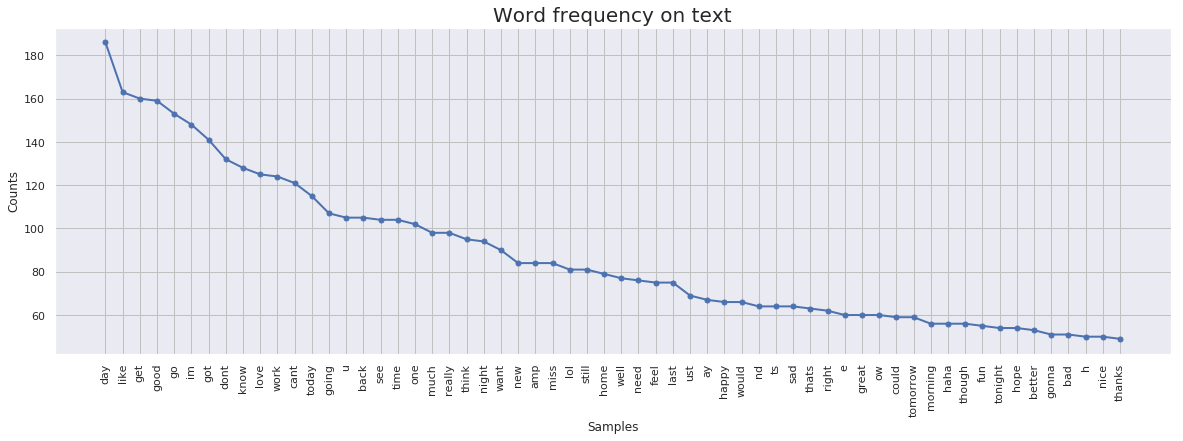

In [9]:
test['text'] = test['text'].str.replace('[^a-z ]','')
test['text'] = test['text'].apply(lambda x: x.lower())

freq_dist = FreqDist([word for comment in test['text'] for word in comment.split() if word not in eng_stopwords])
plt.figure(figsize=(20, 6))
plt.title('Word frequency on text').set_fontsize(20)
freq_dist.plot(60, marker='.', markersize=10)
plt.show()

# Let's take a look if the text size seems to have an impact on the selected text size

It seems that the text length is nicely distributed along with the values and the selected text size has most of its values very short, with less than 10 characters.

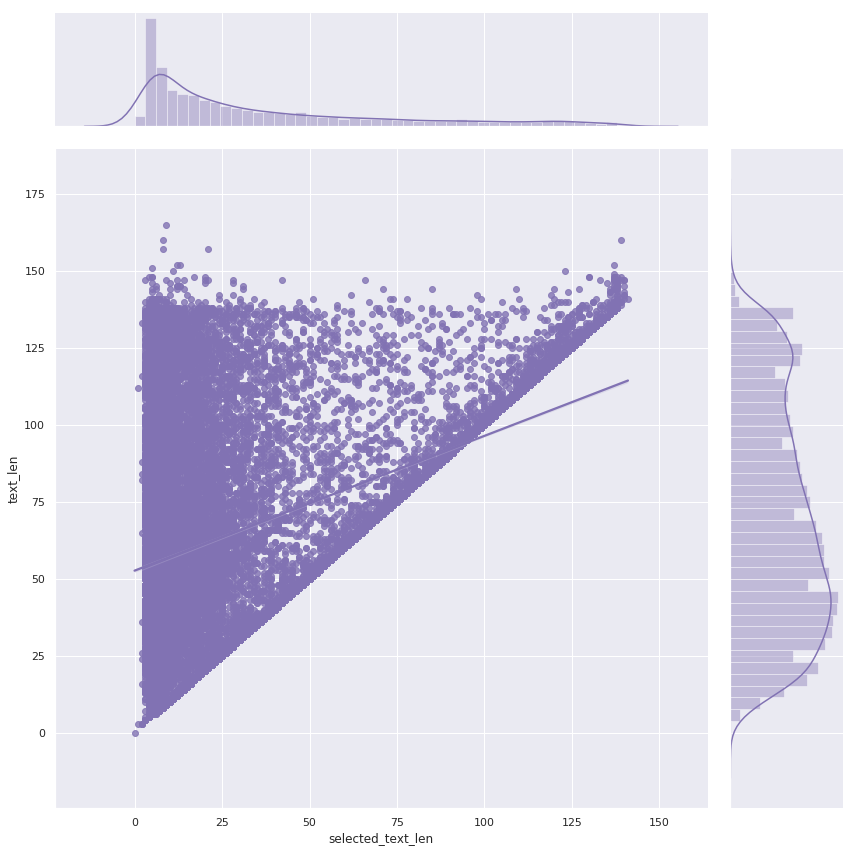

In [10]:
sns.jointplot("selected_text_len", "text_len", data=train, kind="reg", color="m", height=12)
plt.show()

# And now text word count

Again the text word count has a nice distribution along with the values with a small peak around 10 words and the selected text word count has most of its values around with less than 3 words.

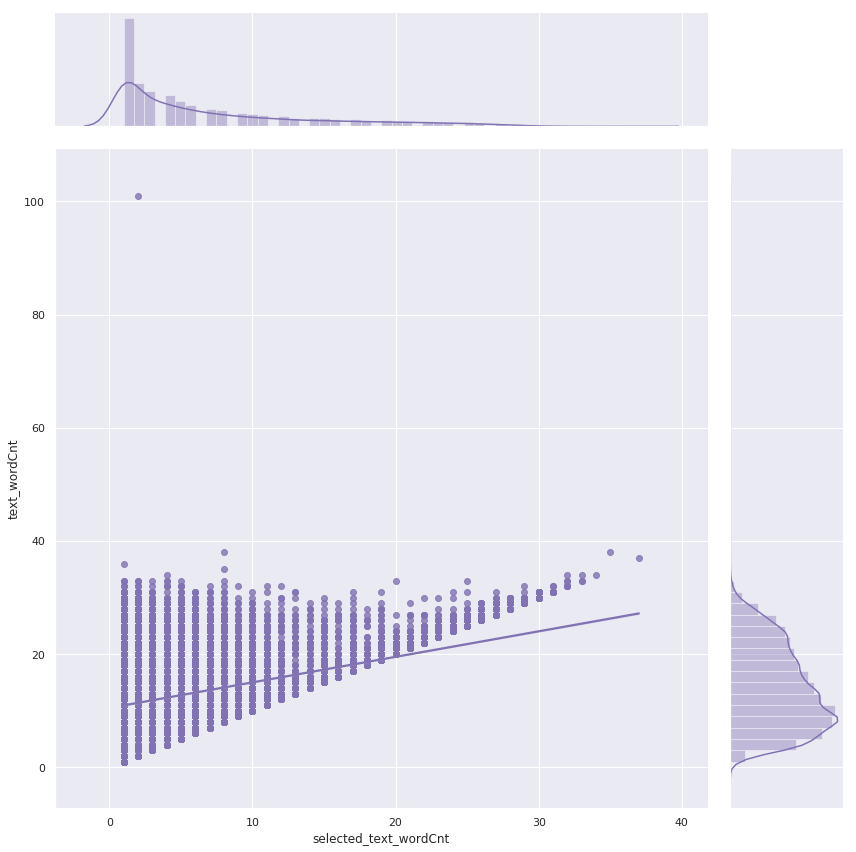

In [11]:
sns.jointplot("selected_text_wordCnt", "text_wordCnt", data=train, kind="reg", color="m", height=12)
plt.show()

# Train/validation split

In [12]:
train_df, validation_df = train_test_split(train, test_size=0.2, random_state=SEED)

print('Train set size: %s' % len(train_df))
print('Validation set size: %s' % len(validation_df))

Train set size: 21988
Validation set size: 5498


# Let's evaluate some heuristic models

## Last 5 words

In [13]:
# Heuristic model
train_df["prediction"] = train_df["text"].apply(lambda x: " ".join(x.strip().split(' ')[-5:]))
validation_df["prediction"] = validation_df["text"].apply(lambda x: " ".join(x.strip().split(' ')[-5:]))
# Metric does not works with empty labels
train_df["prediction"] = train_df["prediction"].apply(lambda x: '.' if x.strip() == '' else x)
validation_df["prediction"] = validation_df["prediction"].apply(lambda x: '.' if x.strip() == '' else x)

evaluate_model(train_df, validation_df)

Train set Jaccard: 0.376
Validation set Jaccard: 0.379

Metric by sentiment

Sentiment == positive
Train set Jaccard: 0.260
Validation set Jaccard: 0.260

Sentiment == negative
Train set Jaccard: 0.288
Validation set Jaccard: 0.291

Sentiment == neutral
Train set Jaccard: 0.529
Validation set Jaccard: 0.526


## First 5 words

In [14]:
# Heuristic model
train_df["prediction"] = train_df["text"].apply(lambda x: " ".join(x.strip().split(' ')[5:]))
validation_df["prediction"] = validation_df["text"].apply(lambda x: " ".join(x.strip().split(' ')[5:]))
# Metric does not works with empty labels
train_df["prediction"] = train_df["prediction"].apply(lambda x: '.' if x.strip() == '' else x)
validation_df["prediction"] = validation_df["prediction"].apply(lambda x: '.' if x.strip() == '' else x)

evaluate_model(train_df, validation_df)

Train set Jaccard: 0.301
Validation set Jaccard: 0.303

Metric by sentiment

Sentiment == positive
Train set Jaccard: 0.181
Validation set Jaccard: 0.170

Sentiment == negative
Train set Jaccard: 0.207
Validation set Jaccard: 0.216

Sentiment == neutral
Train set Jaccard: 0.462
Validation set Jaccard: 0.459


## Same as text

In [15]:
# Heuristic model
train_df["prediction"] = train_df["text"]
validation_df["prediction"] = validation_df["text"]
# Metric does not works with empty labels
train_df["prediction"] = train_df["prediction"].apply(lambda x: '.' if x.strip() == '' else x)
validation_df["prediction"] = validation_df["prediction"].apply(lambda x: '.' if x.strip() == '' else x)

evaluate_model(train_df, validation_df)

Train set Jaccard: 0.586
Validation set Jaccard: 0.596

Metric by sentiment

Sentiment == positive
Train set Jaccard: 0.316
Validation set Jaccard: 0.324

Sentiment == negative
Train set Jaccard: 0.339
Validation set Jaccard: 0.347

Sentiment == neutral
Train set Jaccard: 0.970
Validation set Jaccard: 0.967


## Last 20 characters

In [16]:
# Heuristic model
train_df["prediction"] = train_df["text"].apply(lambda x: " ".join(x.split()[-20:]))
validation_df["prediction"] = validation_df["text"].apply(lambda x: " ".join(x.split()[-20:]))
# Metric does not works with empty labels
train_df["prediction"] = train_df["prediction"].apply(lambda x: '.' if x.strip() == '' else x)
validation_df["prediction"] = validation_df["prediction"].apply(lambda x: '.' if x.strip() == '' else x)

evaluate_model(train_df, validation_df)

Train set Jaccard: 0.579
Validation set Jaccard: 0.590

Metric by sentiment

Sentiment == positive
Train set Jaccard: 0.314
Validation set Jaccard: 0.322

Sentiment == negative
Train set Jaccard: 0.337
Validation set Jaccard: 0.345

Sentiment == neutral
Train set Jaccard: 0.955
Validation set Jaccard: 0.954


# Test set predictions

In [17]:
test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
submission = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')
submission["selected_text"] = test["text"]
submission.to_csv("submission.csv", index=False)
display(submission.head(10))

,textID,selected_text
0,11aa4945ff,http://twitpic.com/67swx - i wish i was calli...
1,fd1db57dc0,i'm done.haha. HOUSE MD marathon ulet
2,2524332d66,I'm concerned for that family
3,0fb19285b2,HEY GUYS IT'S WORKING NO NEED TO WORRY. i have...
4,e6c9e5e3ab,26th February
5,311d2b185b,Tracy and Berwick breaks my achy breaky heart ...
6,95dfefd4e7,Well off 2 bed...cant wait 2 party 4 Mother's ...
7,739f17cfe1,Oh yeah the camera clipping problems with Void...
8,c6322a85c2,_Layne hmm.. what's ur fav movie?? tv shows??
9,b4401d6b4d,"salt and vinegar, cheese and onion make your ..."
